# Model Zoo (Dense)

In [3]:
%env CUDA_VISIBLE_DEVICES=1

import numpy as np
import torch

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

from torch.utils.data import Subset

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import torchvision.models as models
from torchvision.models import vgg19, resnet50, resnet18, resnet34, resnet101 
import timm # state-of-the-art (ViTs...)
from huggingface_hub import hf_hub_download

# from src.model_serving.model_server import *
import matplotlib.pyplot as plt

from datetime import datetime
import time

env: CUDA_VISIBLE_DEVICES=1


In [4]:
# https://github.com/chenyaofo/pytorch-cifar-models
MODELS_V1 = [
    'mobilenetv2_x0_5',
    'mobilenetv2_x0_75',
    'mobilenetv2_x1_0',
    'mobilenetv2_x1_4',
    'repvgg_a0',
    'repvgg_a1',
    'repvgg_a2',
    'resnet20',
    'resnet32',
    'resnet44',
    'resnet56',
    'shufflenetv2_x0_5',
    'shufflenetv2_x1_0',
    'shufflenetv2_x1_5',
    'shufflenetv2_x2_0',
    'vgg11_bn',
    'vgg13_bn',
    'vgg16_bn',
    'vgg19_bn',
 ]
VISION_TRANSFORMERS = [
    'vit_small_patch16_384',
    'vit_base_patch16_384',
    'vit_large_patch16_384',
]
CONVNEXTS = [
    'convnext-tiny',
    'convnext-base',
]

V1_MODELS_UPSTREAM = "chenyaofo/pytorch-cifar-models"

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
print(f"available_gpus: {len(available_gpus)}") 

Using cuda device
available_gpus: 1


In [9]:
'''
from src.model_serving.model_server import *
import matplotlib.pyplot as plt

def profile_pt_model_(model_zoo, model_id: str, test_data: Dataset, latency_sample=1000):
    """
    Profile a pytorch model using all data in test_data and measure latency by 
    performing at most `latency_sample` number of queries.
    """
    print(f"Start profiling {model_id} ...")

    size = len(test_data)
    correct = 0
    with torch.no_grad():
        for X, y in DataLoader(test_data, batch_size=256):
            X, y = X.to(device), y.to(device)
            pred = model_zoo[model_id](X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    latencies = []
    for X, y in DataLoader(test_data, batch_size=1):
        X, y = X.to(device), y.to(device)
        start = time.perf_counter()
        pred = model_zoo[model_id](X)
        latencies.append((time.perf_counter() - start) * 1000) # convert to ms
        if len(latencies) >= latency_sample:
            break

    plt.cla()
    plt.hist(latencies, 20)
    plt.title(f"Latencies PDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_PDF_for_{model_id}.png")

    plt.cla()
    plt.hist(latencies, histtype='step', cumulative=True)
    plt.title(f"Latencies CDF for {model_id}")
    plt.xlabel("Latency (ms)")
    plt.savefig(f"figures/Latencies_CDF_for_{model_id}.png")

    accuracy = correct / size
    latency = np.mean(latencies)
    return accuracy, latency
'''

'\nfrom src.model_serving.model_server import *\nimport matplotlib.pyplot as plt\n\ndef profile_pt_model_(model_zoo, model_id: str, test_data: Dataset, latency_sample=1000):\n    """\n    Profile a pytorch model using all data in test_data and measure latency by \n    performing at most `latency_sample` number of queries.\n    """\n    print(f"Start profiling {model_id} ...")\n\n    size = len(test_data)\n    correct = 0\n    with torch.no_grad():\n        for X, y in DataLoader(test_data, batch_size=256):\n            X, y = X.to(device), y.to(device)\n            pred = model_zoo[model_id](X)\n            correct += (pred.argmax(1) == y).type(torch.float).sum().item()\n    \n    latencies = []\n    for X, y in DataLoader(test_data, batch_size=1):\n        X, y = X.to(device), y.to(device)\n        start = time.perf_counter()\n        pred = model_zoo[model_id](X)\n        latencies.append((time.perf_counter() - start) * 1000) # convert to ms\n        if len(latencies) >= latency_samp

In [10]:
# !pip install huggingface_hub -U

In [55]:
model_zoo = {}

def load_model(model_name: str, dataset: str):

    print("load model...")
    
    if dataset == "cifar10":
        n_classes = 10 
    elif dataset == "cifar100":
        n_classes = 100
    else: 
        raise ValueError(f"Unsupported dataset: {args.dataset}")

    print("model_name: {} w/ dataset: {} (n_classes: {})".format(model_name, dataset, n_classes))
    
    if model_name in MODELS_V1:
        model_id = f'{dataset}_{model_name}'
        model = torch.hub.load(V1_MODELS_UPSTREAM, model_id, pretrained=True)
    elif model_name in VISION_TRANSFORMERS or model_name in CONVNEXTS:
        MODEL_REPO = f'tjang31/{model_name}-{dataset}'
        checkpoint_path = hf_hub_download(repo_id=MODEL_REPO, filename="pytorch_model.bin")
        state_dict = torch.load(checkpoint_path, map_location='cpu')

        model = timm.create_model(model_name, pretrained=False)
        model.head = nn.Linear(model.head.in_features, n_classes)
        model.load_state_dict(state_dict)
    else:
        raise ValueError(f"Model {model_id} not available.")
    
    model.eval()
    return model

# TODO 
model_names = MODELS_V1 + VISION_TRANSFORMERS # + CONVNEXTS

In [19]:
# e.g. 
model = load_model('vit_base_patch16_384', dataset)

/tmp/ipykernel_1775492/2874188987.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


In [20]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [22]:
model_names

['mobilenetv2_x0_5',
 'mobilenetv2_x0_75',
 'mobilenetv2_x1_0',
 'mobilenetv2_x1_4',
 'repvgg_a0',
 'repvgg_a1',
 'repvgg_a2',
 'resnet20',
 'resnet32',
 'resnet44',
 'resnet56',
 'shufflenetv2_x0_5',
 'shufflenetv2_x1_0',
 'shufflenetv2_x1_5',
 'shufflenetv2_x2_0',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'vit_small_patch16_384',
 'vit_base_patch16_384',
 'vit_large_patch16_384']

In [23]:
for model_name in model_names:
    print("loading... ", model_name)
    model = load_model(model_name, dataset)
    model_zoo[model_name] = model

print(f"Model Zoo contains {len(model_zoo)} models:")
for model_name in model_zoo:
    print(f" - {model_name}")

loading...  mobilenetv2_x0_5


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  mobilenetv2_x0_75
loading...  mobilenetv2_x1_0


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  mobilenetv2_x1_4
loading...  repvgg_a0


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  repvgg_a1


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  repvgg_a2


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  resnet20
loading...  resnet32
loading...  resnet44


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  resnet56
loading...  shufflenetv2_x0_5


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  shufflenetv2_x1_0
loading...  shufflenetv2_x1_5


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  shufflenetv2_x2_0
loading...  vgg11_bn


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  vgg13_bn
loading...  vgg16_bn


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  vgg19_bn


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  vit_small_patch16_384


/tmp/ipykernel_1775492/2874188987.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


loading...  vit_base_patch16_384
loading...  vit_large_patch16_384
Model Zoo contains 22 models:
 - mobilenetv2_x0_5
 - mobilenetv2_x0_75
 - mobilenetv2_x1_0
 - mobilenetv2_x1_4
 - repvgg_a0
 - repvgg_a1
 - repvgg_a2
 - resnet20
 - resnet32
 - resnet44
 - resnet56
 - shufflenetv2_x0_5
 - shufflenetv2_x1_0
 - shufflenetv2_x1_5
 - shufflenetv2_x2_0
 - vgg11_bn
 - vgg13_bn
 - vgg16_bn
 - vgg19_bn
 - vit_small_patch16_384
 - vit_base_patch16_384
 - vit_large_patch16_384


In [25]:
# model_zoo['vit_base_patch16_384']

In [56]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010)
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

def get_preprocessor(model_name:str, dataset: str):

    # print("get_preprocessor for {} - {}".format(model_name, dataset))
    
    if dataset == "cifar10":
        _mean = cifar10_mean
        _std = cifar10_std
    elif dataset == "cifar100":
        _mean = cifar100_mean
        _std = cifar100_std
    else: 
        raise ValueError(f"Unsupported dataset: {dataset}")

    if model_name in MODELS_V1:
        preprocessor = transforms.Compose([
          transforms.Resize(32),
          transforms.CenterCrop(32),
          transforms.ToTensor(),
          transforms.Lambda(lambda t: t[:3, ...]),  # remove the alpha channel
          transforms.Normalize(_mean, _std),
          ])
    elif model_name in VISION_TRANSFORMERS or model_name in CONVNEXTS:
        preprocessor = transforms.Compose([
          transforms.Resize((384, 384)),
          transforms.ToTensor(),
          transforms.Normalize(_mean, _std),
          ])
    else:
        raise ValueError(f"Model {model_name} not available.")
    
    return preprocessor

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [57]:
def get_eval_loader(dataset='cifar10', root='./data', transform=None, eval_size=5000, batch_size=8, shuffle=False):

    print("get_eval_loader - {}".format(dataset))
    
    if dataset == 'cifar10':
        _dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    elif dataset == 'cifar100':
        _dataset = datasets.CIFAR100(root=root, train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset. Choose 'cifar10' or 'cifar100'.")

    # Random subset for evaluation
    
    indices = np.random.choice(len(_dataset), eval_size, replace=False)
    eval_data = Subset(_dataset, indices)

    # DataLoader for evaluation
    eval_loader = DataLoader(eval_data, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    
    return eval_loader

In [58]:
def evaluate_model(model, data_loader, device):
    model = model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    total_time = 0

    data_processed = 0 
    last_logged = 0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in data_loader:
            
            images, labels = images.to(device), labels.to(device)
            
            start_time = time.time()
            outputs = model(images)
            latency = time.time() - start_time
            total_time += latency
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            data_processed += labels.size(0)
            
            if data_processed - last_logged >= 500:
                print(f"Processed {data_processed}/{len(data_loader.dataset)} images...")
                last_logged = data_processed

    accuracy = 100 * correct / total
    avg_latency = total_time / len(data_loader)
    
    return accuracy, avg_latency

In [59]:
def profile_pt_models(dataset):

    model_zoo_ = {}
    for model_name in model_names:
        print("loading... ", model_name)
        model = load_model(model_name, dataset)
        model_zoo_[model_name] = model

    results = {}

    for model_name, model in model_zoo_.items():
    
        transform = get_preprocessor(model_name, dataset)
        eval_loader = get_eval_loader(dataset=dataset, root='./data', transform=transform, eval_size=5000, batch_size=8, shuffle=False)
    
        print(f"Evaluating {model_name}...")
        accuracy, latency = evaluate_model(model, eval_loader, device)
        results[model_name] = {'accuracy': accuracy, 'latency': latency}
        print(f"{model_name}: Accuracy = {accuracy:.2f}%, Latency = {latency:.6f} seconds")
    
    for model_name, metrics in results.items():
        print(f"Model: {model_name}, Accuracy: {metrics['accuracy']:.2f}%, Latency: {metrics['latency']:.6f} seconds")

    return results

# model zoo for CIFAR-10

In [47]:
cifar10_results = profile_pt_models(dataset = "cifar10")

{'mobilenetv2_x0_5': {'accuracy': 93.14, 'latency': 0.003704711151123047},
 'mobilenetv2_x0_75': {'accuracy': 94.08, 'latency': 0.0037242748260498046},
 'mobilenetv2_x1_0': {'accuracy': 93.94, 'latency': 0.0036737422943115233},
 'mobilenetv2_x1_4': {'accuracy': 94.24, 'latency': 0.0037275585174560547},
 'repvgg_a0': {'accuracy': 94.32, 'latency': 0.004106401824951172},
 'repvgg_a1': {'accuracy': 95.5, 'latency': 0.004398415374755859},
 'repvgg_a2': {'accuracy': 95.22, 'latency': 0.004276940536499023},
 'resnet20': {'accuracy': 92.68, 'latency': 0.0017449386596679688},
 'resnet32': {'accuracy': 93.7, 'latency': 0.002664299774169922},
 'resnet44': {'accuracy': 93.92, 'latency': 0.0033150314331054686},
 'resnet56': {'accuracy': 94.26, 'latency': 0.004426126480102539},
 'shufflenetv2_x0_5': {'accuracy': 90.6, 'latency': 0.004627672195434571},
 'shufflenetv2_x1_0': {'accuracy': 93.74, 'latency': 0.004462507247924805},
 'shufflenetv2_x1_5': {'accuracy': 93.7, 'latency': 0.004531122589111328}

In [48]:
latencies = [metrics['latency'] for model_name, metrics in results.items()]
accuracies = [metrics['accuracy'] for model_name, metrics in results.items()]

mobilenetv2_x0_5, acc: 93.14, mean latency: 0.004 ms
mobilenetv2_x0_75, acc: 94.08, mean latency: 0.004 ms
mobilenetv2_x1_0, acc: 93.94, mean latency: 0.004 ms
mobilenetv2_x1_4, acc: 94.24, mean latency: 0.004 ms
repvgg_a0, acc: 94.32, mean latency: 0.004 ms
repvgg_a1, acc: 95.5, mean latency: 0.004 ms
repvgg_a2, acc: 95.22, mean latency: 0.004 ms
resnet20, acc: 92.68, mean latency: 0.002 ms
resnet32, acc: 93.7, mean latency: 0.003 ms
resnet44, acc: 93.92, mean latency: 0.003 ms
resnet56, acc: 94.26, mean latency: 0.004 ms
shufflenetv2_x0_5, acc: 90.6, mean latency: 0.005 ms
shufflenetv2_x1_0, acc: 93.74, mean latency: 0.004 ms
shufflenetv2_x1_5, acc: 93.7, mean latency: 0.005 ms
shufflenetv2_x2_0, acc: 93.68, mean latency: 0.005 ms
vgg11_bn, acc: 93.22, mean latency: 0.001 ms
vgg13_bn, acc: 93.72, mean latency: 0.001 ms
vgg16_bn, acc: 94.3, mean latency: 0.002 ms
vgg19_bn, acc: 93.92, mean latency: 0.002 ms
vit_small_patch16_384, acc: 98.38, mean latency: 0.004 ms
vit_base_patch16_384

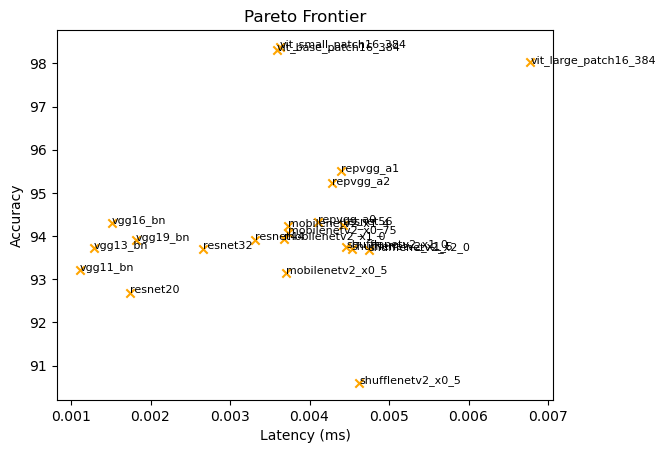

In [51]:
for model_name, metrics in results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms")
    
plt.scatter(latencies, accuracies, label="Models", color='orange', marker='x')

for model_name, metrics in results.items():
    plt.text(metrics['latency'], metrics['accuracy'], model_name, fontsize=8)

plt.title("Pareto Frontier")
plt.xlabel("Latency (ms)")
plt.ylabel("Accuracy")

current = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"figures/Pareto_Frontier_{current}.png")

In [41]:
def get_n_params(model):
    return sum(p.numel() for p in model.parameters())

get_n_params(model_zoo['resnet18'])

11689512

In [43]:
for model_name, metrics in results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms, num_of_parameters: {get_n_params(model_zoo[model_name])}")

resnet18, acc: 69.94, mean latency: 0.003 ms, num_of_parameters: 11689512
resnet50, acc: 75.96, mean latency: 0.005 ms, num_of_parameters: 25557032
resnet101, acc: 77.74, mean latency: 0.010 ms, num_of_parameters: 44549160
vgg16, acc: 71.62, mean latency: 0.002 ms, num_of_parameters: 138357544
vgg19, acc: 72.18, mean latency: 0.002 ms, num_of_parameters: 143667240
densenet121, acc: 74.58, mean latency: 0.014 ms, num_of_parameters: 7978856
densenet201, acc: 76.82, mean latency: 0.023 ms, num_of_parameters: 20013928
mobilenet_v2, acc: 71.92, mean latency: 0.004 ms, num_of_parameters: 3504872
inception_v3, acc: 69.56, mean latency: 0.011 ms, num_of_parameters: 27161264
efficientnet_b0, acc: 77.64, mean latency: 0.006 ms, num_of_parameters: 5288548
efficientnet_b7, acc: 74.1, mean latency: 0.021 ms, num_of_parameters: 66347960
squeezenet1_0, acc: 58.64, mean latency: 0.002 ms, num_of_parameters: 1248424
alexnet, acc: 56.64, mean latency: 0.001 ms, num_of_parameters: 61100840
googlenet, acc

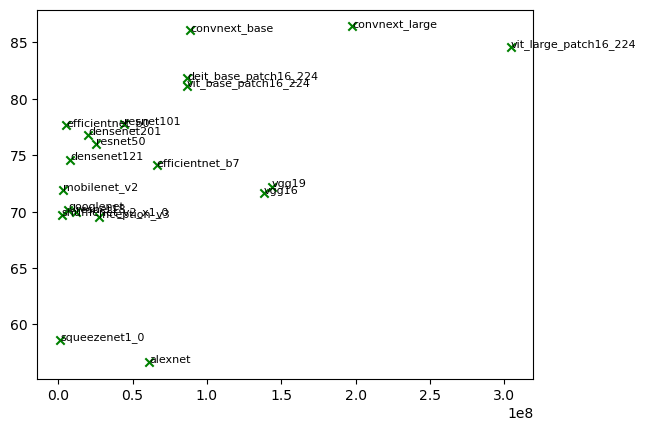

In [48]:
num_of_params = [get_n_params(model_zoo[model_name]) for model_name, metrics in results.items()]
    
plt.scatter(num_of_params, accuracies, label="Models", color='green', marker='x')

for model_name, metrics in results.items():
    plt.text(get_n_params(model_zoo[model_name]), metrics['accuracy'], model_name, fontsize=8)

# plt.title("Pareto Frontier")
# plt.xlabel("Latency (ms)")
# plt.ylabel("Num of Params")

# current = datetime.now().strftime("%Y%m%d_%H%M%S")
# plt.savefig(f"figures/Pareto_Frontier_{current}.png")
    

# model zoo for CIFAR-100

In [61]:
cifar100_results = profile_pt_models(dataset = "cifar100")

loading...  mobilenetv2_x0_5
load model...
model_name: mobilenetv2_x0_5 w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x0_5-9f915757.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_mobilenetv2_x0_5-9f915757.pt
100%|██████████| 3.29M/3.29M [00:00<00:00, 37.3MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x0_75-d7891e60.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_mobilenetv2_x0_75-d7891e60.pt


loading...  mobilenetv2_x0_75
load model...
model_name: mobilenetv2_x0_75 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 5.86M/5.86M [00:00<00:00, 57.1MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  mobilenetv2_x1_0
load model...
model_name: mobilenetv2_x1_0 w/ dataset: cifar100 (n_classes: 100)


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x1_0-1311f9ff.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_mobilenetv2_x1_0-1311f9ff.pt
100%|██████████| 9.21M/9.21M [00:00<00:00, 82.9MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  mobilenetv2_x1_4
load model...
model_name: mobilenetv2_x1_4 w/ dataset: cifar100 (n_classes: 100)


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x1_4-8a269f5e.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_mobilenetv2_x1_4-8a269f5e.pt
100%|██████████| 17.4M/17.4M [00:00<00:00, 122MB/s] 
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  repvgg_a0
load model...
model_name: repvgg_a0 w/ dataset: cifar100 (n_classes: 100)


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar100_repvgg_a0-2df1edd0.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_repvgg_a0-2df1edd0.pt
100%|██████████| 30.6M/30.6M [00:00<00:00, 87.3MB/s]


loading...  repvgg_a1
load model...
model_name: repvgg_a1 w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar100_repvgg_a1-c06b21a7.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_repvgg_a1-c06b21a7.pt
100%|██████████| 49.6M/49.6M [00:00<00:00, 105MB/s] 


loading...  repvgg_a2
load model...
model_name: repvgg_a2 w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar100_repvgg_a2-8e71b1f8.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_repvgg_a2-8e71b1f8.pt
100%|██████████| 103M/103M [00:01<00:00, 87.0MB/s] 


loading...  resnet20
load model...
model_name: resnet20 w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet20-23dac2f1.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_resnet20-23dac2f1.pt
100%|██████████| 1.11M/1.11M [00:00<00:00, 16.6MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet32-84213ce6.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_resnet32-84213ce6.pt


loading...  resnet32
load model...
model_name: resnet32 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 1.88M/1.88M [00:00<00:00, 24.4MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet44-ffe32858.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_resnet44-ffe32858.pt


loading...  resnet44
load model...
model_name: resnet44 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 2.64M/2.64M [00:00<00:00, 30.3MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar100_resnet56-f2eff4c8.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_resnet56-f2eff4c8.pt


loading...  resnet56
load model...
model_name: resnet56 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 3.41M/3.41M [00:00<00:00, 37.4MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar100_shufflenetv2_x0_5-1977720f.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_shufflenetv2_x0_5-1977720f.pt


loading...  shufflenetv2_x0_5
load model...
model_name: shufflenetv2_x0_5 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 1.83M/1.83M [00:00<00:00, 24.4MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar100_shufflenetv2_x1_0-9ae22beb.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_shufflenetv2_x1_0-9ae22beb.pt


loading...  shufflenetv2_x1_0
load model...
model_name: shufflenetv2_x1_0 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 5.34M/5.34M [00:00<00:00, 53.4MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar100_shufflenetv2_x1_5-e2c85ad8.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_shufflenetv2_x1_5-e2c85ad8.pt


loading...  shufflenetv2_x1_5
load model...
model_name: shufflenetv2_x1_5 w/ dataset: cifar100 (n_classes: 100)


100%|██████████| 10.0M/10.0M [00:00<00:00, 82.1MB/s]
Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


loading...  shufflenetv2_x2_0
load model...
model_name: shufflenetv2_x2_0 w/ dataset: cifar100 (n_classes: 100)


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar100_shufflenetv2_x2_0-e7e584cd.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_shufflenetv2_x2_0-e7e584cd.pt
100%|██████████| 21.4M/21.4M [00:00<00:00, 74.8MB/s]


loading...  vgg11_bn
load model...
model_name: vgg11_bn w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg11_bn-57d0759e.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_vgg11_bn-57d0759e.pt
100%|██████████| 37.4M/37.4M [00:00<00:00, 91.8MB/s]


loading...  vgg13_bn
load model...
model_name: vgg13_bn w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg13_bn-5ebe5778.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_vgg13_bn-5ebe5778.pt
100%|██████████| 38.1M/38.1M [00:00<00:00, 161MB/s] 


loading...  vgg16_bn
load model...
model_name: vgg16_bn w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg16_bn-7d8c4031.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_vgg16_bn-7d8c4031.pt
100%|██████████| 58.4M/58.4M [00:00<00:00, 120MB/s] 


loading...  vgg19_bn
load model...
model_name: vgg19_bn w/ dataset: cifar100 (n_classes: 100)


Using cache found in /home/dsanyal7/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar100_vgg19_bn-b98f7bd7.pt" to /home/dsanyal7/.cache/torch/hub/checkpoints/cifar100_vgg19_bn-b98f7bd7.pt
100%|██████████| 78.7M/78.7M [00:00<00:00, 195MB/s] 


loading...  vit_small_patch16_384
load model...
model_name: vit_small_patch16_384 w/ dataset: cifar100 (n_classes: 100)


/tmp/ipykernel_1775492/1706363269.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


loading...  vit_base_patch16_384
load model...
model_name: vit_base_patch16_384 w/ dataset: cifar100 (n_classes: 100)
loading...  vit_large_patch16_384
load model...
model_name: vit_large_patch16_384 w/ dataset: cifar100 (n_classes: 100)
get_preprocessor for mobilenetv2_x0_5 - cifar100
get_eval_loader - cifar100


100%|██████████| 169M/169M [00:03<00:00, 53.7MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Evaluating mobilenetv2_x0_5...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
mobilenetv2_x0_5: Accuracy = 71.04%, Latency = 0.003705 seconds
get_preprocessor for mobilenetv2_x0_75 - cifar100
get_eval_loader - cifar100
Files already downloaded and verified
Evaluating mobilenetv2_x0_75...
Processed 504/5000 images...
Processed 1008/5000 images...
Processed 1512/5000 images...
Processed 2016/5000 images...
Processed 2520/5000 images...
Processed 3024/5000 images...
Processed 3528/5000 images...
Processed 4032/5000 images...
Processed 4536/5000 images...
mobilenetv2_x0_75: Accuracy = 74.42%, Latency = 0.003691 seconds
get_preprocessor for mobilenetv2_x1_0 - cifar100
get_eval_loader - cifar100
Files already downloaded an

NameError: name 'result' is not defined

In [63]:
# tentative;
cifar100_results = {
    'mobilenetv2_x0_5': {'accuracy': 71.04, 'latency': 0.003705},
    'mobilenetv2_x0_75': {'accuracy': 74.42, 'latency': 0.003691},
    'mobilenetv2_x1_0': {'accuracy': 74.44, 'latency': 0.003612},
    'mobilenetv2_x1_4': {'accuracy': 76.04, 'latency': 0.003700},
    'repvgg_a0': {'accuracy': 76.24, 'latency': 0.004198},
    'repvgg_a1': {'accuracy': 76.44, 'latency': 0.004643},
    'repvgg_a2': {'accuracy': 77.24, 'latency': 0.004182},
    'resnet20': {'accuracy': 68.78, 'latency': 0.001706},
    'resnet32': {'accuracy': 69.42, 'latency': 0.002864},
    'resnet44': {'accuracy': 71.52, 'latency': 0.003663},
    'resnet56': {'accuracy': 72.12, 'latency': 0.004722},
    'shufflenetv2_x0_5': {'accuracy': 67.86, 'latency': 0.004706},
    'shufflenetv2_x1_0': {'accuracy': 73.10, 'latency': 0.004691},
    'shufflenetv2_x1_5': {'accuracy': 74.36, 'latency': 0.004913},
    'shufflenetv2_x2_0': {'accuracy': 75.00, 'latency': 0.004969},
    'vgg11_bn': {'accuracy': 70.44, 'latency': 0.001097},
    'vgg13_bn': {'accuracy': 75.16, 'latency': 0.001294},
    'vgg16_bn': {'accuracy': 74.02, 'latency': 0.001660},
    'vgg19_bn': {'accuracy': 74.68, 'latency': 0.002024},
    'vit_small_patch16_384': {'accuracy': 90.82, 'latency': 0.003616},
    'vit_base_patch16_384': {'accuracy': 90.10, 'latency': 0.003929},
    'vit_large_patch16_384': {'accuracy': 90.04, 'latency': 0.007369}
}

In [64]:
latencies = [metrics['latency'] for model_name, metrics in cifar100_results.items()]
accuracies = [metrics['accuracy'] for model_name, metrics in cifar100_results.items()]

In [ ]:
for model_name, metrics in cifar100_results.items():
    print(f"{model_name}, acc: {metrics['accuracy']}, mean latency: {metrics['latency']:.3f} ms")
    
plt.scatter(latencies, accuracies, label="Models", color='orange', marker='x')

for model_name, metrics in cifar100_results.items():
    plt.text(metrics['latency'], metrics['accuracy'], model_name, fontsize=8)

plt.title("Pareto Frontier")
plt.xlabel("Latency (ms)")
plt.ylabel("Accuracy")

current = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f"figures/Pareto_Frontier_{current}.png")